In [83]:

import os
import tqdm

import torch
from torch import nn as nn

import numpy as np
import skimage as ski

import matplotlib.pyplot as plt
from utils import *

## Mixture of Gaussians

We will use a 2D Gaussian mixture model as the data distribution we want to learn. The mixture model is defined as,
$$\rho(x) = \sum_{k=1}^K \alpha_k\mathcal{N}(\mu_k,\Sigma_k)$$

where each Gaussian in the mixture is parameterized by $(\alpha,\mu_x, \mu_y,\sigma_x,\sigma_y)$ i.e., $\Sigma$ is a diagonal matrix with variance $\sigma_x^2$ and $\sigma_y^2$ along the $x$ and $y$ axes, respectively. This allows us to have a closed-form expression for the flows simulated below.

The Gaussian mixture and its sampling function have been implemented for you below. We will consider a special case where the each Gaussian in the mixture lies on a circle.

In [84]:
class GaussianMixture:
    def __init__(self, k=3, dim=2):
        self.k = k
        self.dim = 2
        
        radius = 10
        thetas = torch.arange(k) * 2 * np.pi / k
        self.mus = radius * torch.hstack([torch.cos(thetas)[:, None], torch.sin(thetas)[:, None]])
        self.sigmas = torch.stack([2 * torch.rand(self.dim) for _ in range(k)])
        
        temp = torch.rand(k)
        self.alphas = temp / temp.sum()

    def inv_sigmoid(self, value):
        return torch.log(value/(1-value))
    
    def sample(self, n):
        samples = torch.zeros((n, self.dim), dtype=torch.float32)
        for i in range(n):
            # sample uniform
            r = torch.rand(1).item()
            # select gaussian
            k = 0
            for j, threshold in enumerate(self.alphas.cumsum(dim=0).tolist()):
                if r < threshold:
                    k = j
                    break

            selected_mu = self.mus[k]
            selected_cov = self.sigmas[k] * torch.eye(2)

            # sample from selected gaussian
            lambda_, gamma_ = torch.linalg.eig(selected_cov)
            lambda_ = lambda_.real
            gamma_ = gamma_.real
            

            dimensions = len(lambda_)
            # sampling from normal distribution
            y_s = torch.rand((dimensions * 1, 3))
            x_normal = torch.mean(self.inv_sigmoid(y_s), axis=1).reshape((-1, dimensions))
            # transforming into multivariate distribution
            samples[i] = (x_normal * lambda_) @ gamma_ + selected_mu
            
        return samples

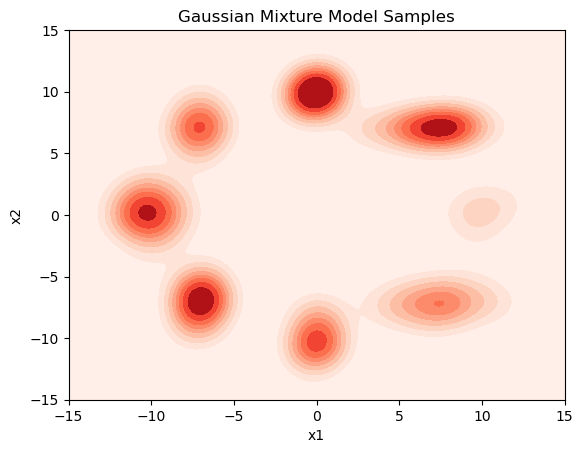

In [85]:
# sample some data and plot the density
import random
SEED = 2024
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

gmm = GaussianMixture(k=8)
samples = gmm.sample(1000)
plot_density_from_samples(samples, filepath='plots/1-samples.png', show=True, save=True)

You will now implement the density function $\rho(x)$.

In [88]:
# density function for a single gaussian distribution given its parameters
import math
def get_gaussian_likelihood(x, mu, sigma, dim=2):
    # ------------
    # FILL THIS IN - START
    # ------------
    sigma= sigma.sqrt()
    return torch.exp(-0.5*(((x-mu)/sigma)**2).sum(dim=-1))/(2*math.pi*torch.prod(sigma))
    
    # ------------
    # FILL THIS IN - END
    # -----------


# density function for the mixture of gaussians
def rho0(samples, alphas, mus, sigmas):
    likelihood = 0
    for i in range(len(mus)):
        likelihood += alphas[i] * get_gaussian_likelihood(samples, mus[i], sigmas[i])
    return likelihood

Let us sample visualize the density $\rho(x)$.

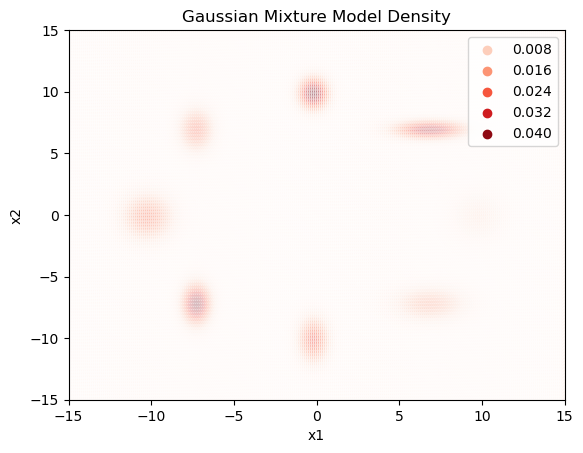

In [89]:
# create a 2D grid of points
x = torch.linspace(-15, 15, 250)
y = torch.linspace(-15, 15, 250)
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
grid_samples = torch.stack([grid_x, grid_y], dim=-1).view(-1, 2)

# plot the density
rho = rho0(grid_samples, gmm.alphas, gmm.mus, gmm.sigmas)
plot_density(grid_samples, rho, filepath='plots/2-density.png')

## Langevin Sampling

To sample from a density $\rho(x)$, Langevin diffusion performs a gradient descent on the negative log-density as follows,
$$x_{k+1} := x_k + \tau \eta(x_k) + \sqrt{2\tau}w_k$$

where $\tau>0$ is the step size and $w_k \sim \mathcal{N}(0,I_d)$ is a standard Gaussian white noise. The score function $\eta(x)$ is defined as, 
$$\eta(x) := \nabla \log \rho(x) = \frac{\nabla \rho(x)}{\rho(x)}.$$

When $\tau \rightarrow 0$, this corresponds to the following Langevin stochastic differential equation (SDE),
$$dx_t = \eta(x_t)dt + \sqrt{2}dw_t$$
where $w_t$ is the Weiner process. We will first compute and display the score as a vector field.

The score function $\eta(x)$ can be estimated from samples if you have access to the density $\rho(x)$ as follows. We already implemented the score function for you.

In [90]:
def eta0(samples, alphas, mus, sigmas):
    x = samples.detach().clone()
    x.requires_grad = True
    p_x = rho0(x, alphas, mus, sigmas)
    
    loss1 = torch.sum(p_x.log())
    loss1.backward()
    output = x.grad

    return output

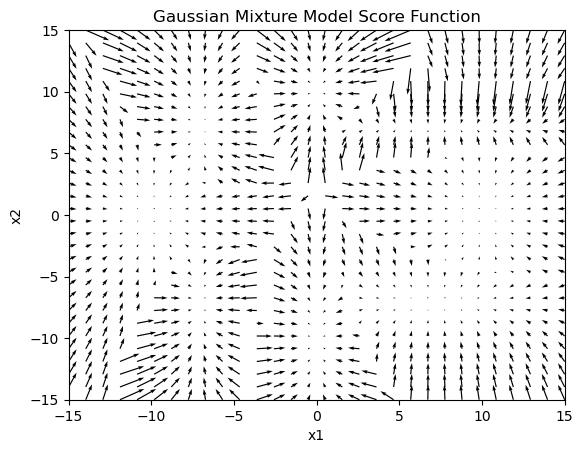

In [91]:
# create a 2D grid of points
x = torch.linspace(-15, 15, 30)
y = torch.linspace(-15, 15, 30)
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
grid_samples = torch.stack([grid_x, grid_y], dim=-1).view(-1, 2)

# plot the score function
eta = eta0(grid_samples, gmm.alphas, gmm.mus, gmm.sigmas)
plot_score_function(grid_samples, eta, filepath='plots/3-score_function.png')

As a reminder, Langevin diffusion performs a gradient descent on the negative log-density as follows,
$$x_{k+1} := x_k + \tau \eta(x_k) + \sqrt{2\tau}w_k$$

where $\tau>0$ is the step size and $w_k \sim \mathcal{N}(0,I_d)$ is a standard Gaussian white noise.

You will now implement the Langevin sampling algorithm.

In [96]:
# let us run the Langevin sampling and display the density as it evolves.

P = 10000 # number of particles
w = 15 # support of the space
z0 = 2 * w * torch.rand((P, 2)) - w  #uniform distribution bt can be anything

T = 10 # final time
N = 25 # number of steps
tau = T / N # step size
z = torch.zeros((P, 2, N))
z[:,:, 0] = z0
for i in tqdm.tqdm(range(N-1)):
    # ------------
    # FILL THIS I
    # N - START
    # ------------
    
    eta = eta0(z[:,:,i], gmm.alphas, gmm.mus, gmm.sigmas)
    z[:,:,i+1] = z[:,:,i] + tau*eta  + (tau*2)**(0.5)*torch.normal(0,1,(P,2))
    
    # ------------
    # FILL THIS IN - END
    # ------------

100%|██████████| 24/24 [00:00<00:00, 211.68it/s]


In [97]:
# create a gif of the density as it evolves
import imageio.v3 as iio
from pygifsicle import optimize

gif_path = 'plots/4-density-from-samples-evolution-ref-to-data-langevin.gif'
frames = []
for i in tqdm.tqdm(range(N)):
    fname = f'plots/density-{i}.jpeg'
    plot_density_from_samples(z[:,:,i], show=False, save=True, filepath=fname)
    frames.append(ski.io.imread(fname))
    os.remove(fname)
    
frames = np.stack(frames)
iio.imwrite(gif_path,frames)
optimize(gif_path)

100%|██████████| 25/25 [00:53<00:00,  2.13s/it]


We will display the generated animation of the samples.

![density from samples evolution ref to data langevin](./plots/4-density-from-samples-evolution-ref-to-data-langevin.gif)

Note that while Langevin can be used for sampling from the density, it needs access to the score function $\eta(x)$ which is not always available. And, in practice Langevin is slow to converge. So we will look at a different method to sample from the density, but which only needs access to the smoothed score $\eta_t(x)$.

### Forward Ulenbeck-Ornstein Process

We will define the forward Ulenbeck-Ornstein process here. It is defined as,
$$dx_t = -x_t dt + \sqrt{2}dw_t$$
where $w_t$ is a Wiener process.

We can numerically approximate the solution of the above SDE using the Euler-Maruyama method as follows,
$$x_{k+1} = x_k - \tau x_k + \sqrt{2\tau}w_t$$

Given $x_0$ and $t$ we can sample $x_t$ using the closed-form solution of the above Ulenbeck-Ornstein process.
$$x_t = e^{-t} x_0 + \sqrt{(1-e^{-2t})}z$$
with $z\sim \mathcal{N}(0,I_d)$.

In the case of the Gaussian mixture that we considered,

$$x_0 \sim \rho_0(x) \stackrel{\Delta}{=} \sum_{k=1}^K \alpha_k\mathcal{N}(\mu_k,\Sigma_k)$$

Now analytically compute the density $\rho_t(x)$ at time $t$.
$$x_t \sim \rho_t(x) \stackrel{\Delta}{=} ...$$

In [99]:
# you will now implement the analytical density at time t using the mean and covariance of the GMM at time zero.
def rhot(x, t, alphas, mus, sigmas):
    # ------------
    # FILL THIS IN - START
    # ------------
    new_mus = mus*math.exp(-t)
    new_sigmas = torch.sqrt(math.exp(-2*t)*(sigmas -1)+1)
    return rho0(x, alphas, new_mus, new_sigmas)
    # ------------
    # FILL THIS IN - END
    # ------------

In [100]:
# let us visualize the density evolution

# create a 2D grid of points
x = torch.linspace(-15, 15, 100)
y = torch.linspace(-15, 15, 100)
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
grid_samples = torch.stack([grid_x, grid_y], dim=-1).view(-1, 2)

frames = []
t_list = torch.arange(0, 10, 0.1)
for i in tqdm.tqdm(range(len(t_list))):
    rho_t = rhot(grid_samples, t_list[i], gmm.alphas, gmm.mus, gmm.sigmas)
    fname = f'plots/density-t-{i}.png'
    plot_density(grid_samples, rho_t, show=False, save=True, filepath=fname)
    frames.append(ski.io.imread(fname))
    os.remove(fname)

gif_path = 'plots/5-density-evolution-data-to-ref-ou.gif'
frames = np.stack(frames)
iio.imwrite(gif_path,frames)
optimize(gif_path)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:31<00:00,  3.16it/s]


We will display the generated animation of the density.

![density evolution data to ref ou](./plots/5-density-evolution-data-to-ref-ou.gif)


Recall that the forward Ulenbeck-Ornstein process is defined as,
$$dx_t = -x_t dt + \sqrt{2}dw_t$$
where $w_t$ is a Wiener process.

We can numerically approximate the solution of the above SDE using the Euler-Maruyama method as follows,
$$x_{k+1} = x_k - \tau x_k + \sqrt{2\tau}w_t$$

Given $x_0$ and $t$ we can sample $x_t$ using the closed-form solution of the above Ulenbeck-Ornstein process.
$$x_t = e^{-t} x_0 + \sqrt{(1-e^{-2t})}z$$
with $z\sim \mathcal{N}(0,I_d)$.

In [101]:
# You will now implement the forward Ornstein-Ulhenbeck process.
class FwdOrnsteinUhlenbeckProcess:
    def __init__(self, tspan=(0., 1.)):
        self.tspan = tspan
        self.N = 2500

    def f(self, u, p, t):
        return -u

    def g(self, u, p, t):
        return np.sqrt(2) * np.ones(u.shape)

    def solve(self, u0, t, type='exact'):
        if type == 'exact':
            return u0 * np.exp(-t) + np.sqrt(1 - np.exp(-2*t)) * np.random.normal(0, 1, u0.shape)                
        if type == 'sde':
            out = u0
            tau  = t / self.N
            for step in range(self.N):
                out = out - tau * out + np.sqrt(2 * tau) * np.random.normal(0, 1, u0.shape)
        return out

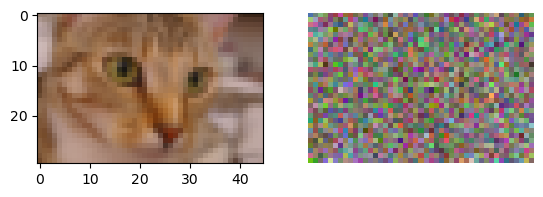

In [102]:
## let us check if the SDE is working correctly

# initilize the process
noising_process = FwdOrnsteinUhlenbeckProcess()

# get data
cat = ski.data.chelsea()
img_size = (int(cat.shape[0]*0.1), int(cat.shape[1]*0.1), 3)
cat = ski.transform.resize(cat, img_size) - 0.5

# call the SDE
u0 = torch.from_numpy(cat.flatten()).float()
out = noising_process.solve(u0, 0.1, type='sde')
out = np.reshape(out, cat.shape, order='C').numpy()

fig, ax = plt.subplots(1, 2)
ax[0].imshow(cat + 0.5)
img = np.divide(out - np.min(out), np.max(out) - np.min(out))
ax[1].imshow(img)
ax[1].axis('off')
plt.show()

So far we checked the evolution of the denisty $\rho_t(x)$ for different values of $t$. Now let us evolve samples through the Ulenbeck-Ornstein process.

In [103]:
# let us get some samples and show the evolution of the density estimated from the samples

P = 1000 # number of particles
samples = gmm.sample(P)

# initialize the foward process
noising_process = FwdOrnsteinUhlenbeckProcess(tspan=(0., 10.))

frames = []
t_list = torch.arange(0, 10, 0.1)
for i in tqdm.tqdm(range(len(t_list))):
    rho_t = noising_process.solve(samples, t_list[i].item(), type='sde')
    fname = f'plots/density-t-{i}.png'
    plot_density_from_samples(rho_t, show=False, save=True, filepath=fname)
    frames.append(ski.io.imread(fname))
    os.remove(fname)

gif_path = 'plots/6-density-from-samples-evolution-data-to-ref-ou.gif'
frames = np.stack(frames)
iio.imwrite(gif_path,frames)
optimize(gif_path)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:55<00:00,  1.81it/s]
gifsicle: warning: trivial adaptive palette (only 235 colors in source)


Let us visualize the evolution of the samples through the Ulenbeck-Ornstein process.

![density from samples evolution data to ref ou](./plots/6-density-from-samples-evolution-data-to-ref-ou.gif)

### Smoothed Score Function

The reverse Ulnebeck-Ornstein process requires us to compute the score function at any time $t$.
$$\eta_t(x) := \nabla \log(\rho_t(x)) = \frac{\nabla \rho_t(x)}{\rho_t(x)}$$

Informally, the score points in the direction of regions with high densities.

Since the density $\rho_t(x)$ for a Gaussian mixture can be computed in closed-form, the score function $\eta_t(x)$ can also be computed in closed-form. However, in a real-scenario, we will not know the density $\rho_t(x)$ and only have access to the samples. So in this case, the score function has to be estimated from the samples.

We will see how to estimate the score function from samples soon.

In [106]:
# You will now implement the new score function at time t
def etat(x, t, alphas, mus, sigmas):
    # ------------
    # FILL THIS IN - START
    # ------------
    new_mus = mus*math.exp(-t)
    new_sigmas = torch.sqrt(math.exp(-2*t)*(sigmas -1)+1)
    return eta0(x, alphas, new_mus, new_sigmas)

    # ------------
    # FILL THIS IN - END
    # ------------

In [107]:
# let us now visualize the score function evolution

# create a 2D grid of points
x = torch.linspace(-15, 15, 30)
y = torch.linspace(-15, 15, 30)
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
grid_samples = torch.stack([grid_x, grid_y], dim=-1).view(-1, 2)

frames = []
t_list = torch.arange(0, 10, 0.1)
for i in tqdm.tqdm(range(len(t_list))):
    eta_t = etat(grid_samples, t_list[i], gmm.alphas, gmm.mus, gmm.sigmas)
    fname = f'plots/score-function-t-{i}.png'
    plot_score_function(grid_samples, eta_t, show=False, save=True, filepath=fname)
    frames.append(ski.io.imread(fname))
    os.remove(fname)

gif_path = 'plots/7-score-function-evolution.gif'
frames = np.stack(frames)
iio.imwrite(gif_path,frames)
optimize(gif_path)

100%|██████████| 100/100 [00:08<00:00, 12.21it/s]
gifsicle: warning: trivial adaptive palette (only 25 colors in source)


### Reverse Ulenbeck-Ornstein Process

We will define the reverse Ulenbeck-Ornstein process here. It is defined as,
$$dy_t = {\left[y_t + (1+\beta)\nabla\log \rho_{T-t}(y_t)\right]}dt + \sqrt{2\beta}dw_t$$
where $w_t$ is a Wiener process, and $\beta \geq 0$ is a parameter controlling the randomness introduced during the reverse process. In standard diffusion models $\beta=1$. And, when $\beta=0$, the reverse process is probability flow ODE sampler we saw in class.

This reverse process can be discretize using the Euler-Maruyama scheme as follows,
$$y_{k+1} = y_{k} + \tau(y_k + (1+\beta)\nabla\log(\rho_{T-t}(y_k))) + \sqrt{2\tau\beta}w_k$$

Here $y_0 \sim \mathcal{N}(0, I_d)$.

Note that here, unlike the Langevin sampling, we only need access to the smooth score $\eta_t(x)$, rather than the true score $\eta(x)$.

In [108]:
# Let us implement the reverse Euler-Maruyama scheme.

P = 1000 # number of particles
y0 = torch.randn((P, 2))

N = 2500 # number of steps
T = 5 # final time
tau = T / N # step size

t = torch.Tensor([T])
beta = 0.1

const_temp1 = torch.Tensor([(1+beta)])
const_temp2 = torch.Tensor([tau * beta])

y = torch.zeros((P, 2, N))
for i in range(N-1):
    # ------------
    # FILL THIS IN - START
    # ------------
    
    eta_t = etat(y[:,:,i], t, gmm.alphas, gmm.mus, gmm.sigmas)
    y[:,:,i+1] = y[:,:,i] + tau*(y[:,:,i] + (1+beta)*eta_t) + (2*tau*beta)**(0.5)*torch.normal(0,1,(P,2))
    t -=  tau
    
    # ------------
    # FILL THIS IN - END
    # ------------

In [109]:
# let us visualize the reverse density evolution

frames = []
for i in tqdm.tqdm(range(0, N-1, 100)):
    plot_density_from_samples(y[:,:,i], filepath=f'plots/reverse-density-{i}.png', show=False, save=True)
    img = ski.io.imread(f'plots/reverse-density-{i}.png')
    frames.append(img)
    os.remove(f'plots/reverse-density-{i}.png')

gif_path = 'plots/8-density-from-samples-evolution-ref-to-data-ou.gif'
frames = np.stack(frames)
iio.imwrite(gif_path,frames)
optimize(gif_path)

  0%|          | 0/25 [00:00<?, ?it/s]/Users/drsatyanarayana/Desktop/Coursework/Deep Learning/homework-3-sachit3022/utils.py:10: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=samples[:, 0], y=samples[:, 1], cmap="Reds", fill=True, thresh=0, bw_adjust=0.5)
100%|██████████| 25/25 [00:09<00:00,  2.66it/s]
gifsicle: warning: trivial adaptive palette (only 158 colors in source)


Let us visualize the evolution of the density in reverse.

![density from samples evolution ref to data ou](./plots/8-density-from-samples-evolution-ref-to-data-ou.gif)

### Denoising Score Matching

Running the reverse Ulenbeck-Ornstein process requires access to the smoothed score $\eta_t(x)=\nabla \log \rho_t(x)$. In practice, we will not have access to the true score function $\eta_t(x)$ or the density $\rho_t(x)$, but only have access to the samples.

So the main idea of Score Matching is to approximate this score using a function computed from the samples $X_t$.
$$\nabla \log \rho_t(x) \approx \phi_{\theta}(x, t)$$
where $\phi_{\theta}(x, t)$ is a neural network with parameters $\theta$.

We will optimize the parameters $\theta$ to minimize the following loss function,
$$\min_{\theta} \mathbb{E}_{t}\left(\lambda_t\mathbb{E}_{x_t}\|\nabla \log \rho_t(x_t) - \phi_{\theta}(x_t, t)\|^2\right)$$
where $\lambda_t$ is a weighting factor that can be used to control the importance of the loss at different times $t$.

From the lecture we saw that $\nabla_{x_t}\log \rho_t(x_t) = \mathbb{E}[\nabla_{x_t}\log \rho_{t|0}(x_t|x_0)|x_t]$, i.e., the score function at time $t$ can be computed as the conditional expectation of the score function of the conditional density $\rho_{t|0}(x_t|x_0)$.

Since we know the forward noising process i.e., $X_t = e^{-t}X_0 + \sqrt{1-e^{-2t}}Z$, we can compute the conditional density in closed-form as $\rho_{t|0}(X_t|X_0) \stackrel{\Delta}{=} \mathcal{N}(X_t;e^{-t}X_0, 1-e^{-2t})$. 

Derive the score function of the conditional distribution,

$$\nabla_{x_t}\log \rho_{t|0}(x_t|x_0) = ...$$

So the overall objective for optimizing the neural network parameters is,
$$\min_{\theta} \mathbb{E}_{t}\left(\lambda_t\mathbb{E}_{(x_0, z) \sim (p(X_0), p(X_t)) }\left\|\nabla_{x_t}\log \rho_{t|0}(x_t|x_0) - \phi_{\theta}(z, t)\right\|^2\right)$$

First generate some samples for training.

In [110]:
N = 20000
Tmin = 1e-2
Tmax = T

Define uniform time distribution between $[10^{-2}, T]$.

In [111]:
x0 = gmm.sample(N)
t_list = torch.linspace(Tmin, Tmax, N)

Let us create $X_t$ from $X_0$.

In [112]:
w = torch.randn((N, 2))
temp = t_list.repeat(2,1).T
xt = torch.exp(-temp) * x0 + torch.sqrt(1 - torch.exp(-2*temp)) * w

Map $t$ into a sane range for ease of training and stack it with $X_t$.

In [113]:
t_nn = (t_list - t_list.min()) / (t_list.max() - t_list.min())
t_nn = 2 * t_nn - 1
u = torch.hstack([xt, t_nn[:,None]])

Now we compute the ground truth output for the neural network i.e., the score function $\nabla_{x_t}\log \rho_{t|0}(x_t|x_0)$.

In [114]:
# ------------
# FILL THIS IN
# ------------
y = (x0 * torch.exp(-1*t_list.reshape(-1,1)) - xt)/ (1 - torch.exp(-2*t_list.reshape(-1,1)))
l_t =    (1 - torch.exp(-2*t_list))/2 #torch.ones_like(t_list)#

Now we define the neural network as a multi-layer perceptron.

In [115]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
            
class MLP(nn.Module):
    def __init__(self, d_in, d_hidden, d_out, dropout=0.1):
        super().__init__()
        layers = nn.ModuleList()
        layers.append(nn.Linear(d_in, d_hidden[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        for i in range(1, len(d_hidden)):
            layers.append(nn.Linear(d_hidden[i-1], d_hidden[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(d_hidden[-1], d_out))
        self.net = nn.Sequential(*layers)
        self.net.apply(weights_init)
    
    def forward(self, x):
        return self.net(x)

Create the neural network model.

In [116]:
import torch.nn as nn

d_in = 3
d_hidden = [128, 128, 128]
d_out = 2
loss = nn.MSELoss(reduction='mean')

In [118]:
model = MLP(d_in, d_hidden, d_out)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

33794


Now we train the network in full batch mode.

In [119]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)
num_epochs = 1000
loss_list = torch.zeros(num_epochs)

for i in tqdm.tqdm(range(num_epochs)):
    optimizer.zero_grad()
    y_pred = model(u)
    l = ((loss(y_pred, y).sum(dim=-1)*l_t)/l_t.sum()).sum()
    l.backward()
    
    optimizer.step()
    loss_list[i] = l.item()
    scheduler.step()

  0%|          | 5/1000 [00:00<01:13, 13.53it/s]

100%|██████████| 1000/1000 [01:05<00:00, 15.23it/s]


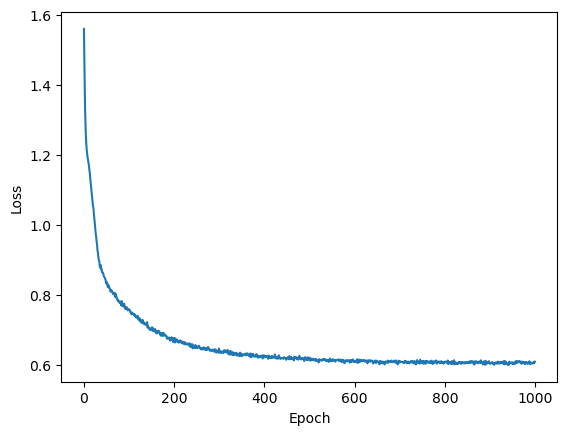

In [120]:
import seaborn as sns
sns.lineplot(x=range(num_epochs), y=loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('plots/9-loss.png')


Let us use the learned model to sample run the reverse Ulenbeck-Ornstein process and sample data points from the distribution.

Recall that, the reverse process can be discretize using the Euler-Maruyama scheme as follows,
$$y_{k+1} = y_{k} + \tau(y_k + (1+\beta)\nabla\log(\rho_{T-t}(y_k))) + \sqrt{2\tau\beta}w_k$$

Here $y_0 \sim \mathcal{N}(0, I_d)$.

In [145]:
# Let us implement the reverse Euler-Maruyama scheme.
model.eval()
P = 1000 # number of particles
y0 = torch.randn((P, 2), requires_grad=False)

N = 2500 # number of steps
T = 5 # final time
tau = T / N # step size


t = torch.Tensor([T])
beta = 0.1

const_temp1 = torch.Tensor([1+beta])
const_temp2 = torch.Tensor([tau * beta])

y = torch.zeros((P, 2, N), requires_grad=False)
y[:,:,0] = y0

for i in tqdm.tqdm(range(N-1)):
    t_temp = 2 * ((t.repeat(P, 1)) / (T)) - 1
    u = torch.hstack([y[:,:,i], t_temp])
    eta_t = model(u)
    # ------------
    # FILL THIS IN - START
    # ------------
    y[:,:,i+1] = y[:,:,i] + tau*(y[:,:,i] + (1+beta)*eta_t) + (2*tau*beta)**(0.5)*torch.normal(0,1,(P,2))
    t -=  tau
    # ------------
    # FILL THIS IN - END
    # ------------

  0%|          | 0/2499 [00:00<?, ?it/s]

100%|██████████| 2499/2499 [00:03<00:00, 768.15it/s] 


In [146]:
#gaussian kernel and density estimation
def gaussian_kernel(x,h):
   return lambda z: (torch.exp(-torch.sum((x-z)**2,dim=-1)/(2*h**2))/(2*math.pi*h**2)**(x.shape[1]/2)).mean()
def density_estimation(x, kernel):
    return torch.stack([kernel(x[i]) for i in range(x.shape[0])])
def kl_divergence(p, q):
    return (p * (torch.log(p) - torch.log(q))).sum()

@torch.no_grad()
def Kl_measure(sampler,x_gen):  
    h = 0.1
    kernel = gaussian_kernel(x_gen,h)
    rho = density_estimation(x_gen, kernel)
    return kl_divergence(rho+1e-10,rho0(samples, sampler.alphas, sampler.mus, sampler.sigmas)+1e-10).item()
   
#esitalte the density of the samples with the gaussian kernel on y

with torch.no_grad():
    vals = []
    print(f"KL measure: {Kl_measure(gmm, y)}")

KL measure: 7.228409290313721


In [147]:
# let us visualize the reverse density evolution

y = y.detach().numpy()

frames = []
for i in tqdm.tqdm(range(0, N-1, 100)):
    plot_density_from_samples(y[:,:,i], filepath=f'plots/reverse-density-{i}.png', show=False, save=True)
    img = ski.io.imread(f'plots/reverse-density-{i}.png')
    frames.append(img)
    os.remove(f'plots/reverse-density-{i}.png')

gif_path = 'plots/10-density-from-samples-evolution-ref-to-data-nn.gif'
frames = np.stack(frames)
iio.imwrite(gif_path,frames)
optimize(gif_path)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:11<00:00,  2.26it/s]
gifsicle: warning: trivial adaptive palette (only 148 colors in source)


Let us visualize the particles sampled using the learned score function.

![density from samples evolution ref to data nn](./plots/10-density-from-samples-evolution-ref-to-data-nn.gif)

Bonus (1 pt): Feel to modify the above algorithm to help improve the efficiency of the sampling/data generation process. You can either modify the training process of the model, or simply improving the sampling process for a standard trained model.